# Project: Neural Network Classifiers (Scikit and Keras)
# Author: Robert Zacchigna

* [Dataset - Categorical Comment Texts](#Dataset)
    * [Columns](#Columns)
* [Imports](#Imports)
* [Classes](#Classes)


* [Load and Clean Comment Data](#Clean_Data)
    * [Clean Text Data: Lower, Remove Punctuation, Remove Stopwords and Stem Words](#Clean_Text)
    * [Split Data Into Train and Test Sets](#Split_Dataset)
        * [Training Set: Feature Data](#Train_Set)
        * [Training Set: Target Data](#Test_Set)


* **[Part 1: Neural Network Classifier with Scikit](#Part_1)**
    * [Create Model Classification Pipeline with TfidfVectorizer and MLPClassifier (Neural Net)](#Part_1-Scikit_Pipe)
	* [Setup Parameter Grid and Fit Pipeline and Parameters to GridSearchCV](#Part_1-Scikit_Grid)
	* [Fit Training Data to Classification Grid to Find the Best Parameters for the Model](#Part_1-Scikit_Fit_Grid)
	* [Display Top Model Scores Found by GridSearchCV](#Part_1-Scikit_Top_Scores)
	* [Best Score Found From Classification Grid](#Part_1-Scikit_Best_Scores)
	* [Best Parameters Found from Classification Grid](#Part_1-Scikit_Best_Params)
	* [Make Predictions Using Classification Grid](#Part_1-Scikit_Predict_Grid)
	* [Calculate Model Prediction Metric Scores: Accuracy, Precision, Recall, and F1](#Part_1-Scikit_Metric_Scores)
	* [Create a Confusion Matrix with the Model Predictions](#Part_1-Scikit_Conf_Mat)


* **[Part 2: Model Analysis](#Part_2)**
    * [Create Function to Build Keras Neural Net](#Part_2-Build_Keras)
	* [Create TfidfVectorizer and KerasClassifier (Neural Net) Models](#Part_2-Create_Keras_Class)
	* [TfidfVectorize and fit_transform Training and Test Sets](#Part_2-Keras_Vect_Fit)
	* [Setup Parameter Grid and Fit the Pipeline and Parameters to GridSearchCV](#Part_2-Keras_Grid)
	* [Fit TfidfVectorized Training data to Keras Grid to Find the Best Parameters for the Model](#Part_2-Keras_Fit_Tfid)
	* [Display Top Model Scores Found by GridSearchCV](#Part_2-Keras_Top_Scores)
	* [Best Score Found from the Keras Grid](#Part_2-Keras_Best_Score)
	* [Best Parameters Found from the Keras Grid](#Part_2-Keras_Best_Params)
	* [Make Predictions Using the Keras Grid](#Part_2-Keras_Predict)
	* [Calculate Model Prediction Metric Scores: Accuracy, Precision, Recall, and F1](#Part_2-Keras_Metric_Scores)
	* [Create a Confusion Matrix with the Model Predictions](#Part_2-Keras_Conf_Mat)


* **[Part 3: Classifying MNIST Images](#Part_3)**
    * [Parse and Split Image Dataset](#Part_3-Parse_Split)
    * [Create Keras Image Classification Model](#Part_3-Create_Model)
    * [Model Summary](#Part_3-Model_Summary)
    * [Train Keras Model](#Part_3-Train_Model)
	* [Display Accuracy and Loss Scores](#Part_3-Keras_Acc_Loss_Scores)

<a id='Dataset'></a>
## Dataset - Categorical Comment Texts

<ins>Columns:</ins><a id='Columns'></a>
* __cat__ – Topical category for the comment text (Sports, Video Games, etc...)
* __txt__ – Comment text

<a id='Imports'></a>
## Imports

In [1]:
import sys
import unicodedata
import numpy as np
import pandas as pd

from notebook import __version__ as nbv

# matplotlib Libraries
import matplotlib.pyplot as plt
from matplotlib import __version__ as mpv

# mlxtend Libraries
from mlxtend.plotting import plot_confusion_matrix
from mlxtend import __version__ as mlxv

# NLTK Libraries
from nltk import __version__ as nltkv
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Sklearn Libraries
from sklearn import __version__ as skv
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score, confusion_matrix

# Keras Libraries
from keras import __version__ as kv
from keras import backend as K
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.convolutional import Conv2D, MaxPooling2D


# Library Versions
lib_info = [('nltk', nltkv), ('numpy', np.__version__), ('keras', kv), ('pandas', pd.__version__),
            ('sklearn', skv), ('mlxtend', mlxv), ('matplotlib', mpv), ('Jupyter Notebook (notebook)', nbv)]

print('Library Versions\n' + '='*16)

for name, vers in lib_info:
    print('{:>27} = {}'.format(name, vers))

Library Versions
                       nltk = 3.5
                      numpy = 1.19.5
                      keras = 2.4.3
                     pandas = 1.3.3
                    sklearn = 0.23.2
                    mlxtend = 0.19.0
                 matplotlib = 3.3.4
Jupyter Notebook (notebook) = 6.4.5


<a id='Classes'></a>
## Classes

In [2]:
class TextNormalizer():
    def __init__(self, data, stop_words):
        self.data = data
        self.stop_words = stop_words
        self.porter = PorterStemmer()
    
    def lower_txt(self, data):
        return data.apply(lambda s: s.lower() if type(s) == str else s)
        
    def remove_punct(self, data):
        punctuation = dict.fromkeys(i for i in range(sys.maxunicode) if unicodedata.category(chr(i)).startswith('P'))

        return data.apply(lambda s: str(s).translate(punctuation))
    
    def remove_stopword(self, data):
        return [' '.join([word for word in s.split()
                          if word not in self.stop_words])
                for s in data]
    
    def word_stem(self, data):
        return data.apply(lambda word: self.porter.stem(str(word)))

<a id='Clean_Data'></a>
## Load and Clean Comment Data

Shuffle the data randomly and select the first 3,000 rows to reduce the data size and speed up analysis (the neural net takes awhile to train with large sets of data)

In [3]:
commentData = pd.read_json('Comment_Data/categorized-comments.jsonl', lines=True)

seed = 34
commentData = commentData.sample(frac=1, random_state=seed)[:3000].reset_index(drop=True)

commentData.head()

,cat,txt
0,sports,"True, but their top 3 is stacked. \n\nCouldn't..."
1,video_games,I had the most fun in halo in custom games
2,video_games,[removed]
3,video_games,"So, whats the point of pushing the payload now?"
4,sports,His normal card is already OP so this one is ...


In [4]:
print('The shape of the data is: {:,} rows and {:,} columns'.format(commentData.shape[0], commentData.shape[1]))

The shape of the data is: 3,000 rows and 2 columns


<a id='Clean_Text'></a>
### Clean Text Data: Lower, Remove Punctuation, Remove Stopwords and Stem Words

In [5]:
stop_words = stopwords.words('english')
txtNorm = TextNormalizer(commentData['txt'], stop_words)

commentData['lower'] = txtNorm.lower_txt(txtNorm.data)
commentData['no_punc'] = txtNorm.remove_punct(commentData['lower'])
commentData['rem_stopwords'] = txtNorm.remove_stopword(commentData['no_punc'])
commentData['word_stem'] = txtNorm.word_stem(commentData['rem_stopwords'])

<a id='Split_Dataset'></a>
### Split Data Into Train and Test Sets

In [6]:
x_train, x_test, y_train, y_test = train_test_split(commentData['word_stem'],
                                                    commentData['cat'],
                                                    train_size=0.70,
                                                    random_state=seed)

<a id='Train_Set'></a>
#### Training Set: Feature Data

In [7]:
x_train.head()

988     ok well wont ever agree pcconsole thing bother...
1788    ive able technically replace iphone battery it...
1782                           dunno timestamp works 2100
2410    nooooooooooooooooooooooooooooooooooooooooooooo...
1540                             blizzard whimsical today
Name: word_stem, dtype: object

<a id='Test_Set'></a>
#### Training Set: Target Data

In [8]:
y_train.head()

988     video_games
1788    video_games
1782    video_games
2410         sports
1540    video_games
Name: cat, dtype: object

<a id='Part_1'></a>
# Part 1: Neural Network Classifier with Scikit

Fit a neural network classifier using scikit-learn on the comments dataset, report: accuracy, precision, recall, F1-score, and confusion matrix.

<a id='Part_1-Scikit_Pipe'></a>
## Create Model Classification Pipeline with TfidfVectorizer and MLPClassifier (Neural Net)

In [9]:
classifier = Pipeline(steps=([
    ('tfidf', TfidfVectorizer()),
    ('clf', MLPClassifier(hidden_layer_sizes=(6, 2), random_state=seed))
]))

<a id='Part_1-Scikit_Grid'></a>
## Setup Parameter Grid and Fit Pipeline and Parameters to GridSearchCV

In [10]:
param_grid = {'clf__activation': ['identity', 'logistic', 'tanh', 'relu'],
              'clf__learning_rate': ['constant', 'invscaling', 'adaptive'],
              'clf__solver': ['lbfgs', 'sgd', 'adam'],
              'clf__alpha': [1e-4, 1e-5, 1e-6]
             }

class_grid = GridSearchCV(classifier, param_grid = param_grid, cv = 5, n_jobs = -1, verbose=2)

<a id='Part_1-Scikit_Fit_Grid'></a>
## Fit Training Data to Classification Grid to Find the Best Parameters for the Model

In [11]:
class_grid.fit(x_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  7.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        MLPClassifier(hidden_layer_sizes=(6, 2),
                                                      random_state=34))]),
             n_jobs=-1,
             param_grid={'clf__activation': ['identity', 'logistic', 'tanh',
                                             'relu'],
                         'clf__alpha': [0.0001, 1e-05, 1e-06],
                         'clf__learning_rate': ['constant', 'invscaling',
                                                'adaptive'],
                         'clf__solver': ['lbfgs', 'sgd', 'adam']},
             verbose=2)

<a id='Part_1-Scikit_Top_Scores'></a>
## Display Top Model Scores Found by GridSearchCV

In [12]:
pd.DataFrame(class_grid.cv_results_).sort_values('mean_test_score', 
                                                 ascending=False)[['params', 'mean_test_score']].head(10)

,params,mean_test_score
53,"{'clf__activation': 'logistic', 'clf__alpha': ...",0.734762
50,"{'clf__activation': 'logistic', 'clf__alpha': ...",0.734762
32,"{'clf__activation': 'logistic', 'clf__alpha': ...",0.734762
35,"{'clf__activation': 'logistic', 'clf__alpha': ...",0.734762
38,"{'clf__activation': 'logistic', 'clf__alpha': ...",0.734762
41,"{'clf__activation': 'logistic', 'clf__alpha': ...",0.734762
44,"{'clf__activation': 'logistic', 'clf__alpha': ...",0.734762
47,"{'clf__activation': 'logistic', 'clf__alpha': ...",0.734762
29,"{'clf__activation': 'logistic', 'clf__alpha': ...",0.734762
5,"{'clf__activation': 'identity', 'clf__alpha': ...",0.730952


<a id='Part_1-Scikit_Best_Scores'></a>
## Best Score Found From Classification Grid

In [13]:
round(class_grid.best_score_, 4)

0.7348

<a id='Part_1-Scikit_Best_Params'></a>
## Best Parameters Found from Classification Grid

In [14]:
print('Best Classification Parameters\n' + '='*30)

for name, val in class_grid.best_params_.items():
    print('{:>16}: {}'.format(name.replace('clf__', ''), val))

Best Classification Parameters
      activation: logistic
           alpha: 0.0001
   learning_rate: constant
          solver: adam


<a id='Part_1-Scikit_Predict_Grid'></a>
## Make Predictions Using Classification Grid

In [15]:
y_pred = class_grid.predict(x_test)

<a id='Part_1-Scikit_Metric_Scores'></a>
## Calculate Model Prediction Metric Scores: Accuracy, Precision, Recall, and F1

In [16]:
accScore = round(accuracy_score(y_test, y_pred), 4) * 100
precScore = round(precision_score(y_test, y_pred, average='weighted', zero_division=0), 4) * 100
recallScore = round(recall_score(y_test, y_pred, average='weighted'), 4) * 100
f1_Score = round(f1_score(y_test, y_pred, average='weighted'), 4) * 100

print('Model Classification Metric Scores\n' + '='*34 + 
      '\n\t Accuracy: {:,.2f}%\n\tPrecision: {:,.2f}%\n\t   Recall: {:,.2f}%\n\t       F1: {:,.2f}%'
      .format(accScore, precScore, recallScore, f1_Score))

Model Classification Metric Scores
	 Accuracy: 75.00%
	Precision: 69.47%
	   Recall: 75.00%
	       F1: 70.75%


<a id='Part_1-Scikit_Conf_Mat'></a>
## Create a Confusion Matrix with the Model Predictions

Text(0, 0.5, 'Actual')

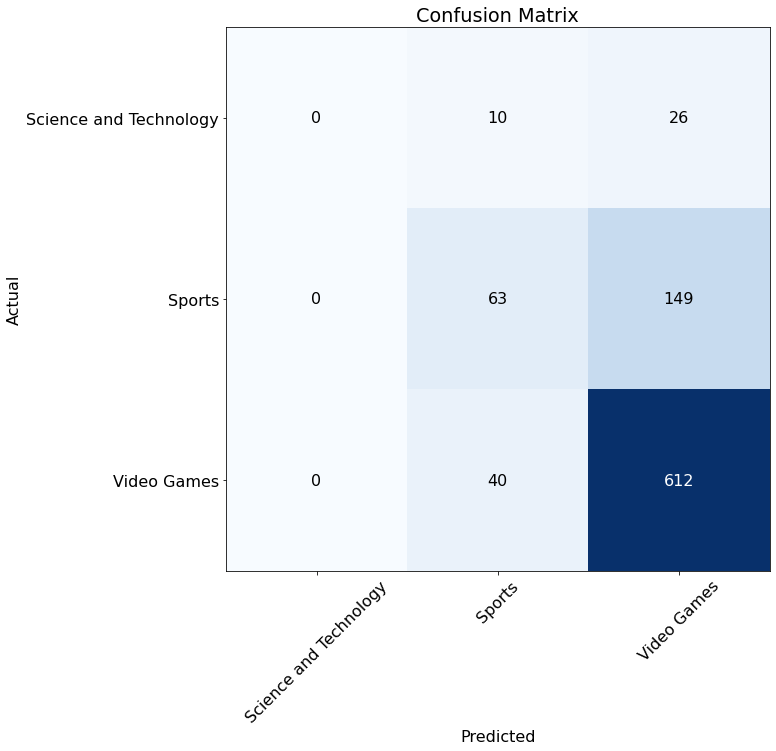

In [17]:
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams.update({'font.size': 16})

plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred), 
                      class_names=['Science and Technology', 'Sports', 'Video Games'], 
                      cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

We can see that model mostly identifies comments as belonging to the "Video Games" category and interestingly enough, nothing to the "Science and Technology" Category.

<a id='Part_2'></a>
# Part 2: Neural Network Classifier with Keras

Fit a neural network classifier using Keras on the comments dataset, report: accuracy, precision, recall, F1-score, and confusion matrix.

<a id='Part_2-Build_Keras'></a>
## Create Function to Build Keras Neural Net

In [18]:
n_features = x_train.shape[0]
n_classes = len(y_train.unique())

def build_network():
    nn = Sequential()
    nn.add(Dense(250, activation='relu', input_dim=(n_features)))
    nn.add(Dense(100, activation='relu'))
    nn.add(Dense(n_classes, activation='softmax'))
    
    nn.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return nn

<a id='Part_2-Create_Keras_Class'></a>
## Create TfidfVectorizer and KerasClassifier (Neural Net) Models

In [19]:
vect = TfidfVectorizer(max_features=n_features)

keras_model = KerasClassifier(build_fn=build_network)

<a id='Part_2-Keras_Vect_Fit'></a>
## TfidfVectorize and fit_transform Training and Test Sets

In [20]:
x_train_vect = vect.fit_transform(x_train).todense()
x_test_vect = vect.fit_transform(x_test).todense()

<a id='Part_2-Keras_Grid'></a>
## Setup Parameter Grid and Fit the Pipeline and Parameters to GridSearchCV

In [21]:
param_grid = {'epochs': [10, 25, 50],
              'batch_size': [10, 25, 50]}

keras_grid = GridSearchCV(keras_model, param_grid = param_grid, cv = 5, n_jobs = -1, verbose=2)

<a id='Part_2-Keras_Fit_Tfid'></a>
## Fit TfidfVectorized Training data to Keras Grid to Find the Best Parameters for the Model

In [22]:
keras_grid.fit(x_train_vect, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.6min finished


Epoch 1/25
210/210 [==============================] - 1s 4ms/step - loss: 0.7951 - accuracy: 0.6824
Epoch 2/25
210/210 [==============================] - 1s 4ms/step - loss: 0.5166 - accuracy: 0.7669
Epoch 3/25
210/210 [==============================] - 1s 4ms/step - loss: 0.2605 - accuracy: 0.8958
Epoch 4/25
210/210 [==============================] - 1s 4ms/step - loss: 0.1531 - accuracy: 0.9487
Epoch 5/25
210/210 [==============================] - 1s 4ms/step - loss: 0.1145 - accuracy: 0.9583
Epoch 6/25
210/210 [==============================] - 1s 4ms/step - loss: 0.0898 - accuracy: 0.9685
Epoch 7/25
210/210 [==============================] - 1s 4ms/step - loss: 0.0977 - accuracy: 0.9600
Epoch 8/25
210/210 [==============================] - 1s 4ms/step - loss: 0.0889 - accuracy: 0.9653
Epoch 9/25
210/210 [==============================] - 1s 4ms/step - loss: 0.0864 - accuracy: 0.9657
Epoch 10/25
210/210 [==============================] - 1s 4ms/step - loss: 0.0969 - accuracy: 0.9578

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000028E2329AB80>,
             n_jobs=-1,
             param_grid={'batch_size': [10, 25, 50], 'epochs': [10, 25, 50]},
             verbose=2)

<a id='Part_2-Keras_Top_Scores'></a>
## Display Top Model Scores Found by GridSearchCV

In [23]:
pd.DataFrame(keras_grid.cv_results_).sort_values('mean_test_score', 
                                                 ascending=False)[['params', 'mean_test_score']].head(10)

,params,mean_test_score
1,"{'batch_size': 10, 'epochs': 25}",0.723333
2,"{'batch_size': 10, 'epochs': 50}",0.722857
4,"{'batch_size': 25, 'epochs': 25}",0.722381
7,"{'batch_size': 50, 'epochs': 25}",0.722381
0,"{'batch_size': 10, 'epochs': 10}",0.721905
6,"{'batch_size': 50, 'epochs': 10}",0.720000
8,"{'batch_size': 50, 'epochs': 50}",0.718571
5,"{'batch_size': 25, 'epochs': 50}",0.717143
3,"{'batch_size': 25, 'epochs': 10}",0.716190


<a id='Part_2-Keras_Best_Score'></a>
## Best Score Found from the Keras Grid

In [24]:
round(keras_grid.best_score_, 4)

0.7233

<a id='Part_2-Keras_Best_Params'></a>
## Best Parameters Found from the Keras Grid

In [25]:
keras_grid.best_params_

{'batch_size': 10, 'epochs': 25}

<a id='Part_2-Keras_Predict'></a>
## Make Predictions Using the Keras Grid

In [26]:
y_pred = keras_grid.predict(x_test_vect)

<a id='Part_2-Keras_Metric_Scores'></a>
## Calculate Model Prediction Metric Scores: Accuracy, Precision, Recall, and F1

In [27]:
accScore = round(accuracy_score(y_test, y_pred), 4) * 100
precScore = round(precision_score(y_test, y_pred, average='weighted', zero_division=0), 4) * 100
recallScore = round(recall_score(y_test, y_pred, average='weighted'), 4) * 100
f1_Score = round(f1_score(y_test, y_pred, average='weighted'), 4) * 100

print('Model Keras Metric Scores\n' + '='*25 + 
      '\n     Accuracy: {:,.2f}%\n    Precision: {:,.2f}%\n       Recall: {:,.2f}%\n\t   F1: {:,.2f}%'
      .format(accScore, precScore, recallScore, f1_Score))

Model Keras Metric Scores
     Accuracy: 66.44%
    Precision: 58.97%
       Recall: 66.44%
	   F1: 61.92%


<a id='Part_2-Keras_Conf_Mat'></a>
## Create a Confusion Matrix with the Model Predictions

Text(0, 0.5, 'Actual')

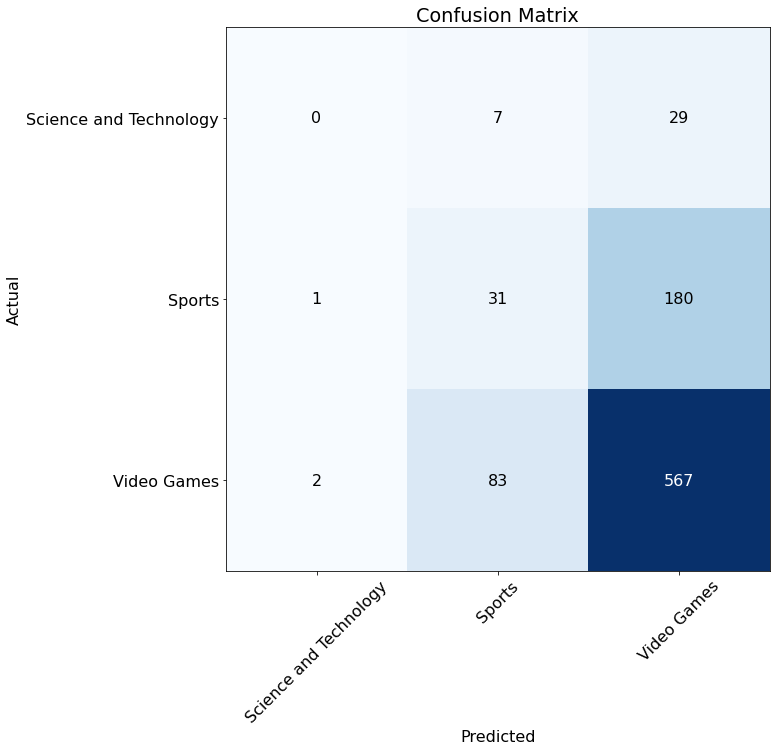

In [28]:
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams.update({'font.size': 16})

plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred), 
                      class_names=['Science and Technology', 'Sports', 'Video Games'], 
                      cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

We can see, just like in the Scikit model, the Keras model mostly identified comments as belonging to the "Video Games" category but this time there were a few comments that were mistaken for the "Science and Technology" category.

<a id='Part_3'></a>
# Part 3: Classifying MNIST Images

Classify MSINT images using a convolutional neural network and report the accuracy of the results.

<a id='Part_3-Parse_Split'></a>
## Parse and Split Image Dataset

In [29]:
# Set that the color channel value will be first
K.set_image_data_format("channels_last")

# Set seed
np.random.seed(0)

# Set image information
channels = 1
height = 28
width = 28

# Load data and target from MNIST data
(data_train, target_train), (data_test, target_test) = mnist.load_data()
                                                                       
# Reshape training image data into features
data_train = data_train.reshape(data_train.shape[0], height, width, channels)

# Reshape test image data into features
data_test = data_test.reshape(data_test.shape[0], height, width, channels)

# Rescale pixel intensity to between 0 and 1
features_train = data_train / 255
features_test = data_test / 255

# One-hot encode target
target_train = np_utils.to_categorical(target_train)
target_test = np_utils.to_categorical(target_test)
number_of_classes = target_test.shape[1]

<a id='Part_3-Create_Model'></a>
## Create Keras Image Classification Model

In [30]:
# Start neural network
network = Sequential()

# Add convolutional layer with 64 filters, a 5x5 window, and ReLU activation function
network.add(Conv2D(filters=64, kernel_size=(5, 5), kernel_initializer='normal', padding='valid',
                   input_shape=(width, height, channels), activation='relu'))

# Add max pooling layer with a 2x2 window
network.add(MaxPooling2D(pool_size=(2, 2)))

# Add dropout layer
network.add(Dropout(0.5))

# Add layer to flatten input
network.add(Flatten())

# # Add fully connected layer of 128 units with a ReLU activation function
network.add(Dense(128, activation="relu"))

# Add dropout layer
network.add(Dropout(0.5))

# Add fully connected layer with a softmax activation function
network.add(Dense(number_of_classes, activation="softmax"))

# Compile neural network
network.compile(loss="categorical_crossentropy", # Cross-entropy
                optimizer="rmsprop", # Root Mean Square Propagation
                metrics=["accuracy"]) # Accuracy performance metric

<a id='Part_3-Model_Summary'></a>
## Model Summary

In [31]:
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

<a id='Part_3-Train_Model'></a>
## Train Keras Model

In [32]:
# Train neural network
history = network.fit(features_train, # Features
                      target_train, # Target
                      epochs=2, # Number of epochs
                      verbose=2, # Print description after each epoch
                      batch_size=1000, # Number of observations per batch
                      validation_data=(features_test, target_test)) # Data for evaluation

Epoch 1/2
60/60 - 29s - loss: 0.5862 - accuracy: 0.8183 - val_loss: 0.1747 - val_accuracy: 0.9515
Epoch 2/2
60/60 - 26s - loss: 0.1977 - accuracy: 0.9424 - val_loss: 0.0870 - val_accuracy: 0.9730


<a id='Part_3-Keras_Acc_Loss_Scores'></a>
## Display Accuracy and Loss Scores 

In [33]:
print('  Keras Image Classification Accuracies\n' + '='*41)

for index, (acc, loss) in enumerate(zip(history.history['accuracy'], history.history['loss'])):
    print('Epoch {:}: Accuracy = {:,.2f}%, Loss = {:,.2f}%'.format(index + 1, acc * 100, loss * 100))

  Keras Image Classification Accuracies
Epoch 1: Accuracy = 81.83%, Loss = 58.62%
Epoch 2: Accuracy = 94.24%, Loss = 19.77%


The model ended with an accuracy score of `~94%`, which is excellent considering it only ran for 2 epochs. 